# Package Installations 

In [1]:
install_packages = False 
if install_packages:
  !pip3 install torch torchvision  

In [2]:
import os 
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import torch
import PIL
from torchvision.transforms import v2


from tensorflow import keras

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model


from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import MobileNet, MobileNetV3Large, MobileNetV3Small, MobileNetV2


from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool2D, MaxPool1D, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense


from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from utils import *
from img_utils import *
from img_utils import plot_hist

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3492/1665301731.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-21 09:15:46.045526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 09:15:46.045600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 09:15:46.107017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable t

# Loading Data 

In [3]:
path = "../nybolig-scrape/output/part_1"
houses_df = data_to_DF(path, max_houses=1000)

In [4]:
from utils import print_DF_price_stats
from utils import remove_outliers
from img_utils import preprocces_data
#Take only Copenhagen, and Ejerlejligheder
# houses_df = houses_df_[(houses_df_['postal_code'] >= 1000) & (houses_df_['postal_code'] <= 2920)]
# houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']

#Get some stat
print_DF_price_stats(houses_df)

#Remove theoutliers 
houses_df = remove_outliers(houses_df, 'price')
print_DF_price_stats(houses_df)

#Aååæ
houses_df = preprocces_data(houses_df)
#drop nana 
houses_df = houses_df.dropna()

Number of datapoints: 880
Mean price: 4172914.772727273
Median price: 3335000.0
Min price: 275000
Max price: 27000000
Standard deviation of price:2732157.7804384604
Number of datapoints: 839
Mean price: 3745183.5518474374
Median price: 3295000.0
Min price: 275000
Max price: 9500000
Standard deviation of price:1780457.0957617785


/mnt/c/Repos/house_price_regression/img_utils.py:136: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['basement_size'] = df["basement_size"].fillna(0)


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

: 

# Setting up splits 

In [ ]:
from sklearn.model_selection import train_test_split
from img_utils import prices_to_n_labels


# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
mean_price = train_df['price'].mean()

#Calculate the MAE for the test set
mae = np.mean(np.abs(test_df['price'] - mean_price))
print(f"Naive Mean absolute error {mae:.2f} ")


Naive Mean absolute error 1418320.03 


In [ ]:
print("Trains Size", len(train_df))
print("Valid Size", len(valid_df))
print("Test Size", len(test_df))

Trains Size 464
Valid Size 116
Test Size 146


# Loading Images

In [ ]:
# As most of the original images are 2100x1400, we resize them to 224x224, as this is what the model operates on
target_width = 224
target_height = 224

resize = True
gray_scale = False
threshhold = False

train_images = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)
validation_images = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)
test_images = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)

# MobileNet: Transfer Learning with Pre-trained Wieghts 

In [ ]:
def build_and_fit_model(pretrained_model, 
                        train_images, train_labels,
                        validation_images, valid_labels,
                        num_classes, 
                        input_shape, model_output:str): 
  """
  Function to build and fit a model with a pretrained model and a new classification layer
  """

  train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, valid_labels))


  #Load the Pretrained Model
  base_model = pretrained_model(weights="imagenet", include_top=False, input_shape = input_shape) 

  # Freeze the pretrained weights
  for layer in base_model.layers:
    layer.trainable = False

  # Create the model with the pretrained model and a new classification layer
  model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.1), 
    #Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear') if model_output == 'continuous' else Dense(num_classes, activation='softmax')
  ])

  #Check which type of model we are building
  if model_output == 'continuous':
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mean_absolute_error', 
                  metrics=['mean_absolute_error'])
  
  if (model_output == 'classification'):
    model.compile(optimizer=Adam(learning_rate=0.001),  
                  loss='categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy' , 
                  metrics=['accuracy'])
  
  #Fit the model 
  fit_history = model.fit(
  train_images, 
  train_labels,
  #steps_per_epoch=8, 
  epochs=100, 
  #verbose = 1,
  #batch_size=32
  validation_data=(validation_images, valid_labels), 
  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
  )
  return model, fit_history

# Binary Model 

In [ ]:
from img_utils import prices_to_n_labels
num_labels = 2
train_labels_binary = prices_to_n_labels(houses_df['price'], train_df['price'], num_labels)
valid_labels_binary = prices_to_n_labels(houses_df['price'], valid_df['price'], num_labels)
test_labels_binary = prices_to_n_labels(houses_df['price'], test_df['price'], num_labels)

[3295000.0]
[3295000.0]
[3295000.0]


In [ ]:
pretrained_model = MobileNetV3Small  
binary_model, binary_fit_history = build_and_fit_model(pretrained_model, 
                                                       train_images, train_labels_binary, 
                                                       validation_images, valid_labels_binary, 
                                                       num_labels, 
                                                       input_shape = (target_width, target_height, 3),
                                                       model_output = 'classification')

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

Plot the training history


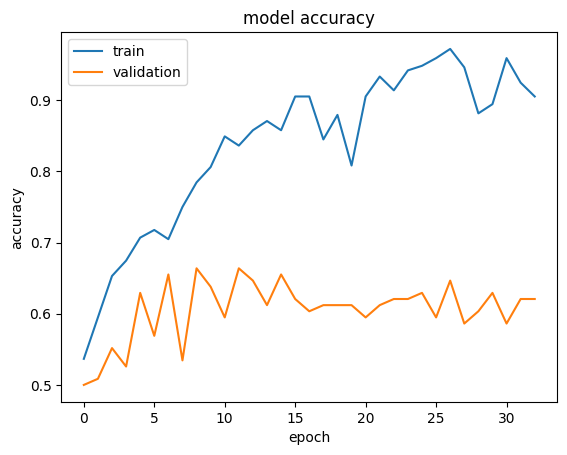

5/5 [==============================] - 1s 285ms/step
[1 0 0 1 1 0 1 0 0 1]
[1 1 1 1 0 1 1 0 1 1]
Accuracy: 0.73
Precision: 0.73
Recall: 0.73


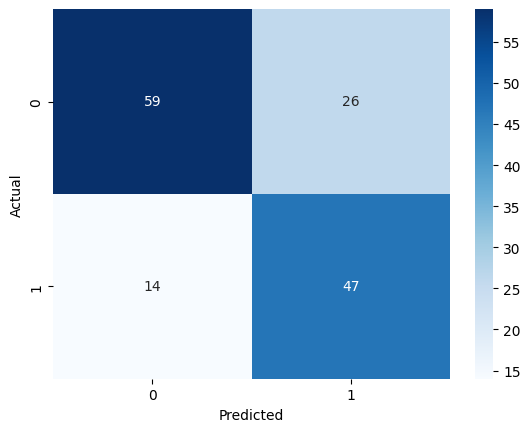

In [ ]:
#Plot the training history
print("Plot the training history")
plot_hist(binary_fit_history)

# Evaluate the model

from img_utils import label_score
binary_model_predictions = binary_model.predict(test_images)
binary_model_predictions = np.argmax(binary_model_predictions, axis=1)
test_labels_binary_ = np.argmax(test_labels_binary, axis=1)

print(binary_model_predictions[:10])
print(test_labels_binary_[:10])

label_score(binary_model_predictions, test_labels_binary_)

# N-Label Model 

In [ ]:
num_labels = 5
train_labels = prices_to_n_labels(houses_df['price'], train_df['price'], num_labels)
valid_labels = prices_to_n_labels(houses_df['price'], valid_df['price'], num_labels)
test_labels = prices_to_n_labels(houses_df['price'], test_df['price'], num_labels)
pretrained_model = MobileNetV3Small 
label_model, label_fit_history = build_and_fit_model(pretrained_model,
                                                      train_images, train_labels, 
                                                      validation_images, valid_labels, 
                                                      num_labels, 
                                                      input_shape = (target_width, target_height, 3),
                                                      model_output='classification')

In [ ]:
#Plot the training history
print("Plot the training history")
plot_hist(label_fit_history)

# Evaluate the model
print("Evaluate the model:")
label_model.evaluate(test_images, test_labels)

from img_utils import label_score
label_model_predictions = label_model.predict(test_images)
label_model_predictions = np.argmax(label_model_predictions, axis=1)
label_model_actual = np.argmax(test_labels, axis=1)
label_score(label_model_predictions, label_model_actual)

In [ ]:
#Save the continous model 
label_model.save('trained_models/MobileNet_5_label.keras')

# Continous Predictions

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_labels = train_df['price']
valid_labels = valid_df['price']
test_labels = test_df['price']

pretrained_model = MobileNetV3Large
input_shape = train_images[0].shape

regression_model, regression_fit_history = build_and_fit_model(pretrained_model,
                                                                train_images, train_labels, 
                                                                validation_images, valid_labels, 
                                                                num_classes= None, 
                                                                input_shape = (target_width, target_height, 3),
                                                                model_output='continuous')      

Epoch 1/100
15/15 [==============================] - 25s 1s/step - loss: 3799559.5000 - mean_absolute_error: 3799504.5000 - val_loss: 3754226.2500 - val_mean_absolute_error: 3754175.2500
Epoch 2/100
15/15 [==============================] - 16s 1s/step - loss: 3761790.5000 - mean_absolute_error: 3761741.5000 - val_loss: 3659537.0000 - val_mean_absolute_error: 3659489.7500
Epoch 3/100
15/15 [==============================] - 15s 1s/step - loss: 3555007.7500 - mean_absolute_error: 3554959.7500 - val_loss: 3249734.0000 - val_mean_absolute_error: 3249683.5000
Epoch 4/100
15/15 [==============================] - 16s 1s/step - loss: 2824466.5000 - mean_absolute_error: 2824411.2500 - val_loss: 2042500.2500 - val_mean_absolute_error: 2042437.5000
Epoch 5/100
15/15 [==============================] - 15s 1s/step - loss: 1618167.0000 - mean_absolute_error: 1618096.2500 - val_loss: 1453638.3750 - val_mean_absolute_error: 1453561.1250
Epoch 6/100
15/15 [==============================] - 15s 1s/step 

In [ ]:
save = True
if save: 
  regression_model.save('trained_models/MobileNet_Continous.keras')

Evaluate the model:
5/5 [==============================] - 5s 536ms/step
R2 score: 0.25
Mean Absolute Error: 1063242.79
Mean Squared Error: 2168792353754.87


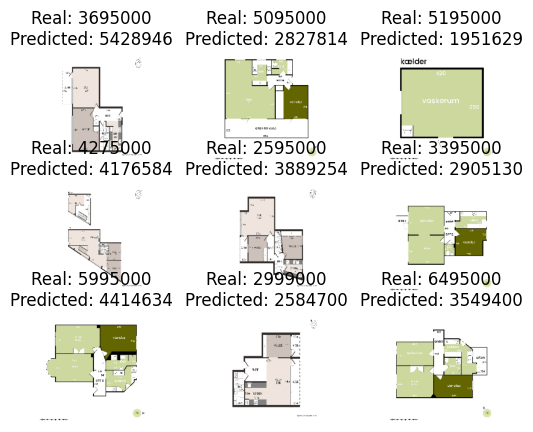

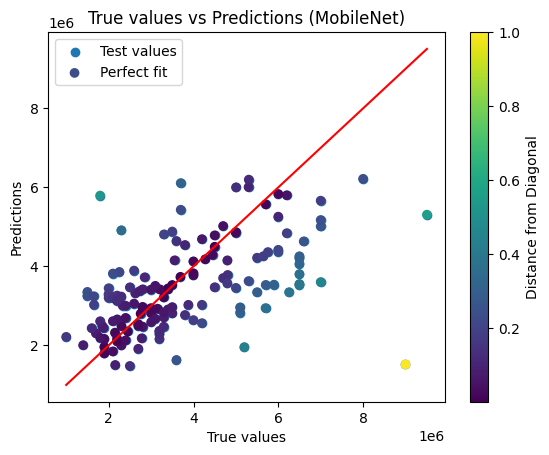

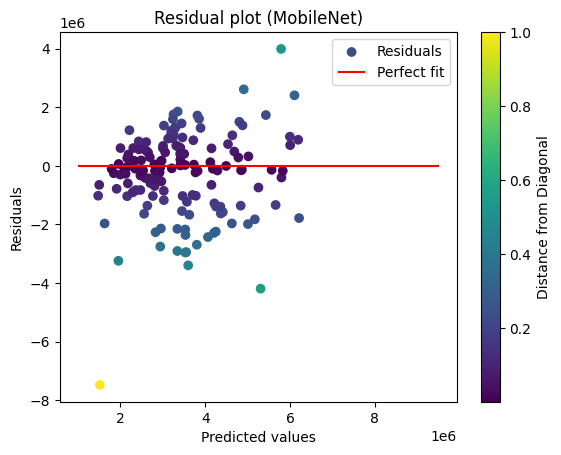

In [ ]:
#Evaluate the model
from img_utils import print_scores_prices, plot_predictions
from utils import plot_regression_results
print("Evaluate the model:")
predicted_prices_cont = regression_model.predict(test_images)
true_prices_cont = test_df['price'].values

print_scores_prices(true_prices_cont, predicted_prices_cont)
plot_predictions(test_images, true_prices_cont, predicted_prices_cont)
plot_regression_results("MobileNet", true_prices_cont , predicted_prices_cont.flatten())

Predicted 3801187.5 True 6495000 Residual -2693812.5 Distance 2693812.5


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
188,Sundevedsgade 4 1. 1751 København V,1751,ejerlejlighed,6495000,126,0,5.0,1858.0,1858.0,-1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(3000, 3000, 3)"


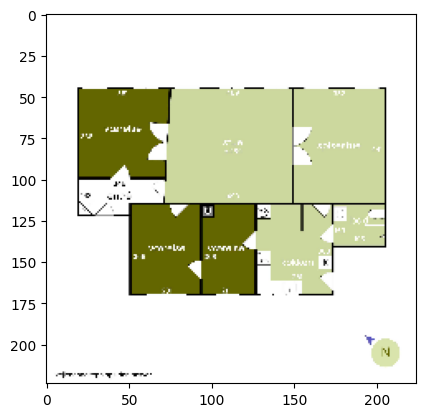

Predicted 2939542.0 True 5695000 Residual -2755458.0 Distance 2755458.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
16,Jyllandsvej 15 1. tv 2000 Frederiksberg,2000,ejerlejlighed,5695000,96,0,3.0,1884.0,2012.0,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(1400, 2100, 3)"


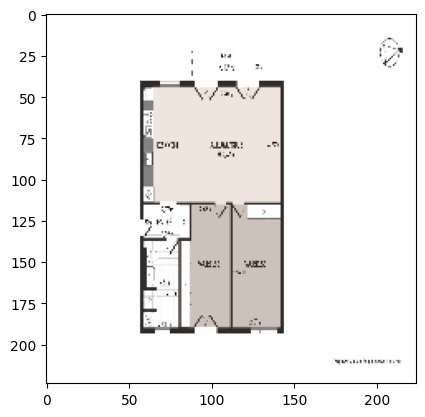

Predicted 3341634.0 True 6250000 Residual -2908366.0 Distance 2908366.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
762,Robert Jacobsens Vej 86 2. p2 2300 København S,2300,ejerlejlighed,6250000,145,0,4.0,2010.0,2010.0,3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(1400, 2100, 3)"


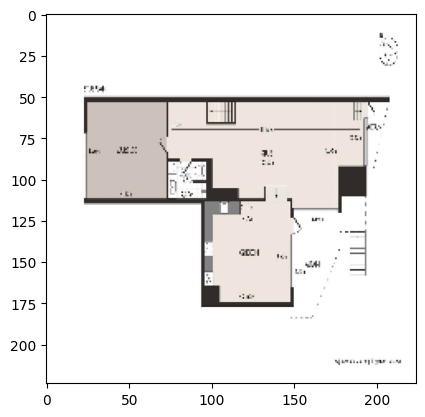

Predicted 3549399.5 True 6495000 Residual -2945600.5 Distance 2945600.5


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
36,Kapelvej 1 3. th. 2200 København N,2200,ejerlejlighed,6495000,83,0,4.0,1891.0,1891.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(3000, 3000, 3)"


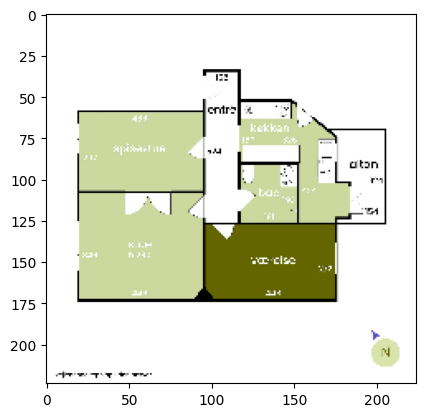

Predicted 3532288.0 True 6495000 Residual -2962712.0 Distance 2962712.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
387,Birkegade 11 4. th. 2200 København N,2200,ejerlejlighed,6495000,88,0,3.0,1892.0,1892.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(3000, 3000, 3)"


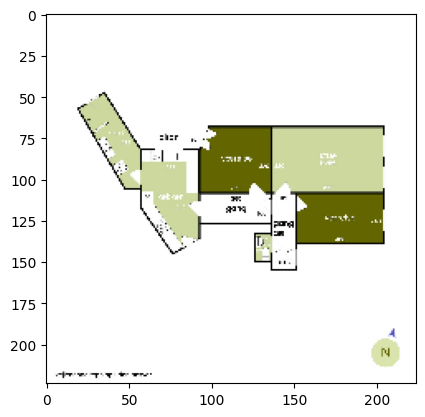

Predicted 1951629.4 True 5195000 Residual -3243370.625 Distance 3243370.625


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
617,Nyborggade 4 st.. 2100 København Ø,2100,ejerlejlighed,5195000,87,0,3.0,1903.0,1903.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(3000, 3000, 3)"


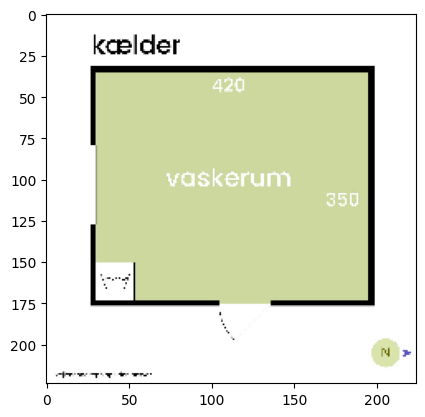

Predicted 3597752.8 True 6995000 Residual -3397247.25 Distance 3397247.25


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
496,Reventlowsgade 26 st. th 1651 København V,1651,ejerlejlighed,6995000,121,0,4.0,1888.0,2000.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(1400, 2100, 3)"


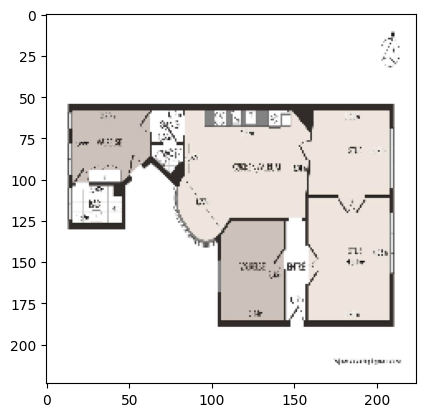

Predicted 5787760.0 True 1795000 Residual 3992760.0 Distance 3992760.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
673,Bellahøjvej 148 st. th 2720 Vanløse,2720,ejerlejlighed,1795000,101,0,2.0,1934.0,1934.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(1400, 2100, 3)"


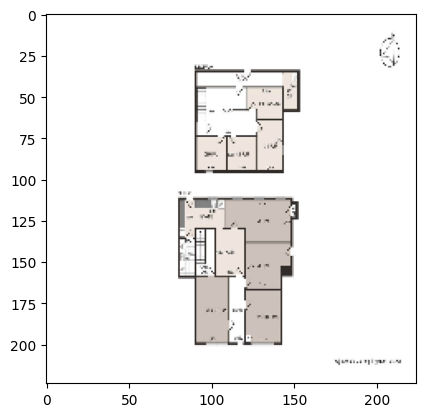

Predicted 5304591.5 True 9500000 Residual -4195408.5 Distance 4195408.5


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
10,Rådhusstræde 7 1. tv. 1466 København K,1466,ejerlejlighed,9500000,149,0,5.0,1798.0,1798.0,-1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(2000, 3000, 3)"


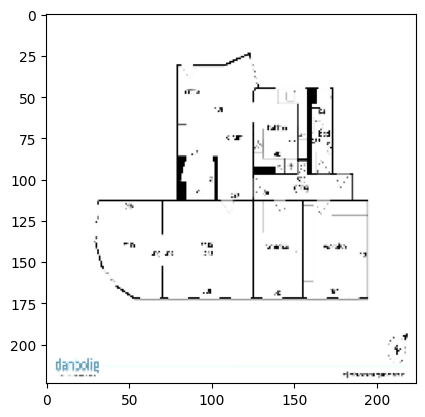

Predicted 1513110.5 True 8995000 Residual -7481889.5 Distance 7481889.5


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
546,Peblinge Dossering 28 4. 2200 København N,2200,ejerlejlighed,8995000,119,0,4.0,1880.0,1880.0,6,"[[[227, 184, 121], [225, 182, 119], [225, 182,...","(1400, 2100, 3)"


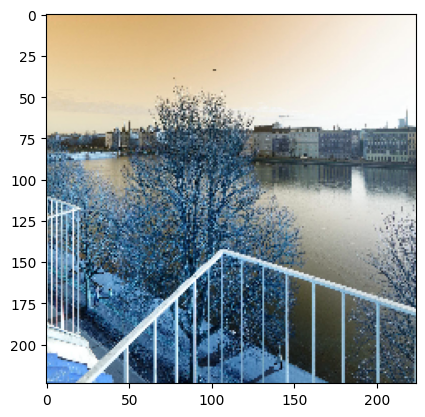

In [ ]:
from utils import top_n_worst
top_n_worst(true_prices_cont, predicted_prices_cont.flatten(), test_df, test_images,  10)

# MobileNet + MLP Features 

In [ ]:
#import mean_absolute_error, CatetoricalCrossentropy, BinaryCrossentropy, Concatenate, l2, l1
from tensorflow.keras.losses import MeanAbsoluteError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Concatenate

def build_and_fit_model(pretrained_model,
                        train_images, train_features, train_labels,
                        validation_images, validation_features, valid_labels,
                        num_classes,
                        input_shape, model_output: str):
  """
  Function to build and fit a model with a pretrained model, features, and a new classification layer
  """

  #Load the Pretrained Model
  base_model = pretrained_model(weights="imagenet", include_top=False, input_shape=input_shape)
  # Freeze the pretrained weights
  for layer in base_model.layers:
    layer.trainable = False

  image_input = Input(shape=input_shape)
  image_features = base_model(image_input)
  image_features = Flatten()(image_features)  
  image_features = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(image_features)
  image_features = layers.Dropout(0.2)(image_features)
  image_features = Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01))(image_features)
  image_features = Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01))(image_features)
  image_features = Dense(64, activation='relu')(image_features)
  image_features = Dense(32, activation='relu')(image_features)
  image_features = Dense(16, activation='relu')(image_features)
  image_features = Dense(8, activation='relu')(image_features)
  image_features = Dense(1, activation='relu')(image_features)
  #image_features = layers.BatchNormalization()(image_features)
  flattened_image_features = Flatten()(image_features)

  # #Features input
  num_features = len(train_features.iloc[0])
  features_input = Input(shape=(num_features,))  
  numeric_features = Dense(9, activation='relu', kernel_regularizer=l2(0.0001))(features_input)
  numeric_features = layers.Dropout(0.02)(numeric_features)
  numeric_features = Dense(9, activation='relu', kernel_regularizer=l1(0.001))(numeric_features)
  numeric_features = layers.Dropout(0.02)(numeric_features)
  numeric_features = Dense(9, activation='relu')(numeric_features)
  numeric_features = Dense(1, activation='linear')(numeric_features)
  numeric_features = Flatten()(numeric_features)
  
  # # Concatenate image and other features
  combined_features = Concatenate()([flattened_image_features, numeric_features])

  # Output layer for classification
  if model_output == 'continuous':
    output_layer = Dense(1, activation='linear', name='output')(combined_features)
  elif model_output == 'classification':
    output_layer = Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid', name='output')(combined_features)

  # Create the model with image and features inputs
  model = Model(inputs=[image_input, features_input], outputs=output_layer)
  #show the model
  model.summary()

  # Compile the model based on output type
  if model_output == 'continuous':
    model.compile(optimizer=Adam(learning_rate=0.02),
                  loss=MeanAbsoluteError(),
                  metrics=['mean_absolute_error'])

  elif model_output == 'classification':
    model.compile(optimizer=Adam(learning_rate=0.05),
                  loss=CategoricalCrossentropy() if num_classes > 1 else BinaryCrossentropy(),
                  metrics=['accuracy'])

  # Fit the model with both images and features
  fit_history = model.fit([train_images, train_features],
                          train_labels,
                          validation_data=([validation_images, validation_features], valid_labels),
                          epochs=200,  # Adjust hyperparameters as needed
                          batch_size=32,
                          callbacks=[EarlyStopping(patience=20, restore_best_weights=True)]
                          )

  return model, fit_history


In [ ]:

pretrained_model = MobileNetV3Large
train_images = train_images
validation_images = validation_images

train_features = train_df.drop(columns=['price', 'image_floorplan', 'address', 'image_resolution', 'type'])
validation_features = valid_df.drop(columns=['price', 'image_floorplan','address', 'image_resolution', 'type'])

train_labels = train_df['price']
valid_labels = valid_df['price']
model_output = 'continuous'
num_classes = None

#train_labels = prices_to_n_labels(houses_df['price'], train_df['price'], num_classes)
#valid_labels = prices_to_n_labels(houses_df['price'], valid_df['price'], num_classes)

input_shape = (target_width, target_height, 3)


In [ ]:
regression_model, regression_fit_history = build_and_fit_model(pretrained_model,
                                                                train_images, train_features, train_labels,
                                                                validation_images, validation_features, valid_labels,
                                                                num_classes,
                                                                input_shape, model_output)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_84 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_84[0][0]']            
 al)                                                                                              
                                                                                                  
 flatten_50 (Flatten)        (None, 47040)                0         ['MobilenetV3large[0][0]']    
                                                                                                  
 dense_255 (Dense)           (None, 512)                  2408499   ['flatten_50[0][0]']   

5/5 [==============================] - 3s 637ms/step
Evaluate the model:
5/5 [==============================] - 4s 720ms/step - loss: 681367.7500 - mean_absolute_error: 681363.0000


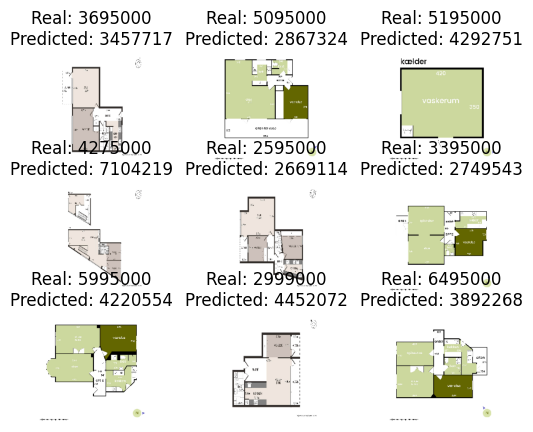

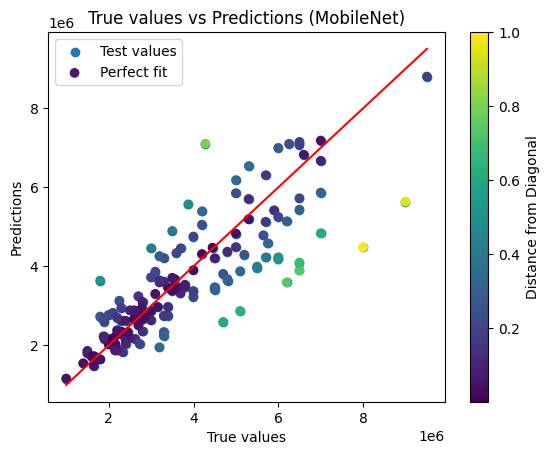

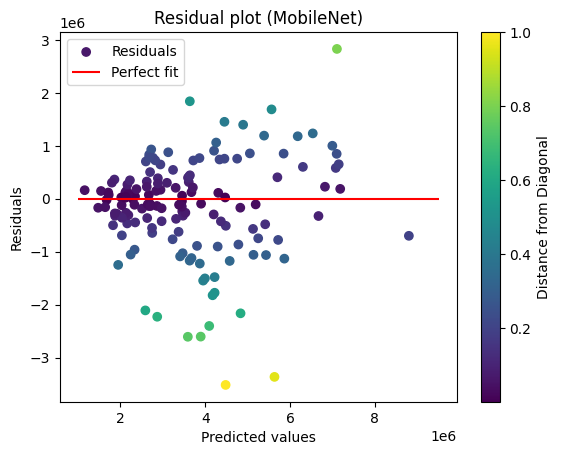

R^2: 0.6839070753515857
Mean Absolute Error: 681363.033390411
Mean Percentage Error: 17.56000807238744
Mean Squared Error: 919082114037.6917


/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [ ]:
from img_utils import print_scores_prices, plot_predictions
from utils import plot_regression_results, regression_stats

test_images = test_images
test_features = test_df.drop(columns=['price', 'image_floorplan', 'address', 'image_resolution', 'type'])
test_labels = test_df['price']


#Predict the labels 
predicted_prices = regression_model.predict([test_images, test_features])

print("Evaluate the model:")
regression_model.evaluate([test_images, test_features], test_labels)  
plot_predictions(test_images, test_labels, predicted_prices)
plot_regression_results("MobileNet", test_labels, predicted_prices.flatten())
regression_stats(test_labels, predicted_prices.flatten())

[ 8 81  3 93 18]
Predicted 3892267.8 True 6495000 Residual -2602732.25 Distance 2602732.25


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
36,Kapelvej 1 3. th. 2200 København N,2200,ejerlejlighed,6495000,83,0,4.0,1891.0,1891.0,4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(3000, 3000, 3)"


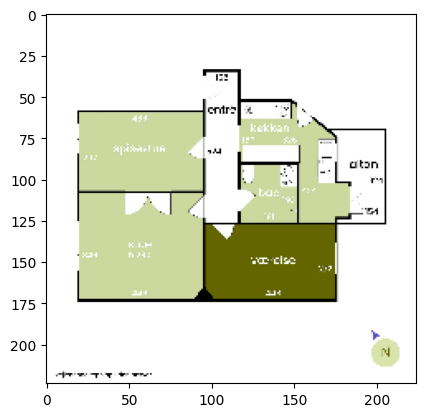

Predicted 3589139.8 True 6195000 Residual -2605860.25 Distance 2605860.25


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
56,Islands Brygge 92 6. 4 2300 København S,2300,ejerlejlighed,6195000,73,0,2.0,2023.0,2023.0,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(1400, 2100, 3)"


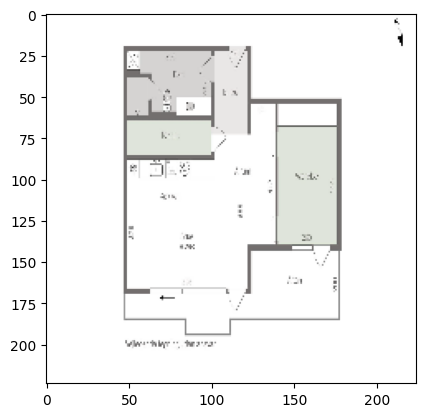

Predicted 7104219.0 True 4275000 Residual 2829219.0 Distance 2829219.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
482,Ørestads Boulevard 57C 3. 325 2300 København S,2300,ejerlejlighed,4275000,144,0,4.0,2005.0,2005.0,0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(1400, 2100, 3)"


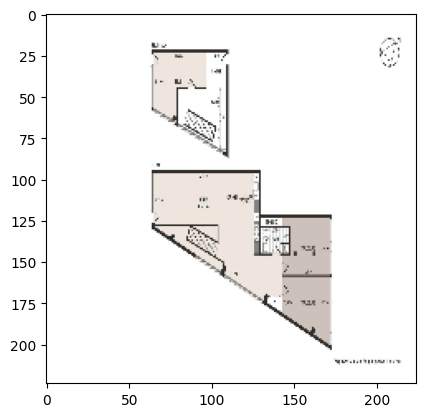

Predicted 5631876.0 True 8995000 Residual -3363124.0 Distance 3363124.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
546,Peblinge Dossering 28 4. 2200 København N,2200,ejerlejlighed,8995000,119,0,4.0,1880.0,1880.0,6,"[[[227, 184, 121], [225, 182, 119], [225, 182,...","(1400, 2100, 3)"


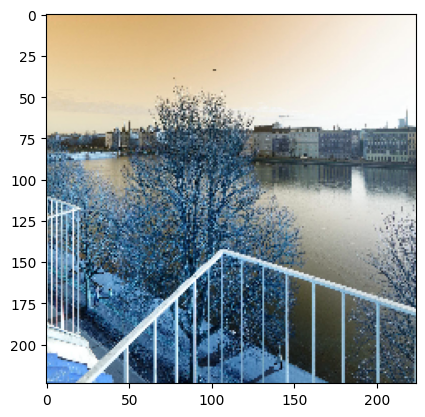

Predicted 4480057.0 True 7995000 Residual -3514943.0 Distance 3514943.0


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan,image_resolution
510,Islands Brygge 76 8. 2 2300 København S,2300,ejerlejlighed,7995000,93,0,3.0,2023.0,2023.0,2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(2100, 2100, 3)"


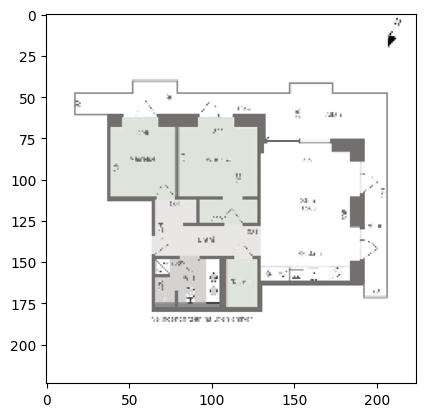

In [ ]:
from utils import top_n_worst
top_n_worst(test_labels.values, predicted_prices.flatten(), test_df, test_images,  5)